In [1]:
from pycap import EnergyStorageDevice,PropertyTree
from pycap import measure_ragone_chart
from numpy import sqrt,log,linalg,inf
from matplotlib import pyplot
%matplotlib inline

In [2]:
R  =100.456   # ohm
R_L=413615.   # ohm
C  =0.0262473 # farad

U_i=2.6       # volt
U_f=1.2       # volt

def setup_ragone_database():
    ragone_database=PropertyTree()
    ragone_database.put_double('discharge_power_lower_limit',1e-5)
    ragone_database.put_double('discharge_power_upper_limit',1e+2)
    ragone_database.put_int   ('steps_per_decade'           ,20)
    ragone_database.put_double('initial_voltage'            ,U_i)
    ragone_database.put_double('final_voltage'              ,U_f)
    ragone_database.put_double('time_step'                  ,5)
    ragone_database.put_int   ('min_steps_per_discharge'    ,2000)
    ragone_database.put_int   ('max_steps_per_discharge'    ,3000)
    return ragone_database

def plot_ragone_chart(P,E_computed,E_exact):
    label_fontsize=30
    tick_fontsize=20
    plot_linewidth=3
    pyplot.figure(figsize=(16,12))
    pyplot.loglog(P,E_computed,'r-s' ,lw=plot_linewidth)
    pyplot.loglog(P,E_exact   ,'k--o',lw=plot_linewidth)
    pyplot.xlabel(r'$\mathrm{Power\  [W]}$',fontsize=label_fontsize)
    pyplot.ylabel(r'$\mathrm{Energy\ [J]}$',fontsize=label_fontsize)
    pyplot.gca().get_yaxis().set_tick_params(labelsize=tick_fontsize)
    pyplot.gca().get_xaxis().set_tick_params(labelsize=tick_fontsize)

# Series RC
The exact answer is given by:
\begin{equation}
E_{exact} = \frac{C}{2} \left( -RP\log\left(\frac{U_0^2}{U_{final}^2}+U_0^2-U_{final}^2\right) \right)
\end{equation}
where:
\begin{equation}
U_0=\frac{U_{initial}}{2}+\sqrt{\frac{U_{initial}^2}{4}-RP}
\end{equation}
The error is computed as $100\times\left\|\frac{E_{computed}-E_{exact}}{E_{computed}}\right\|_\infty$

Failed to discharge at 0.014125 watt
max pecent error = 4.472929e-02


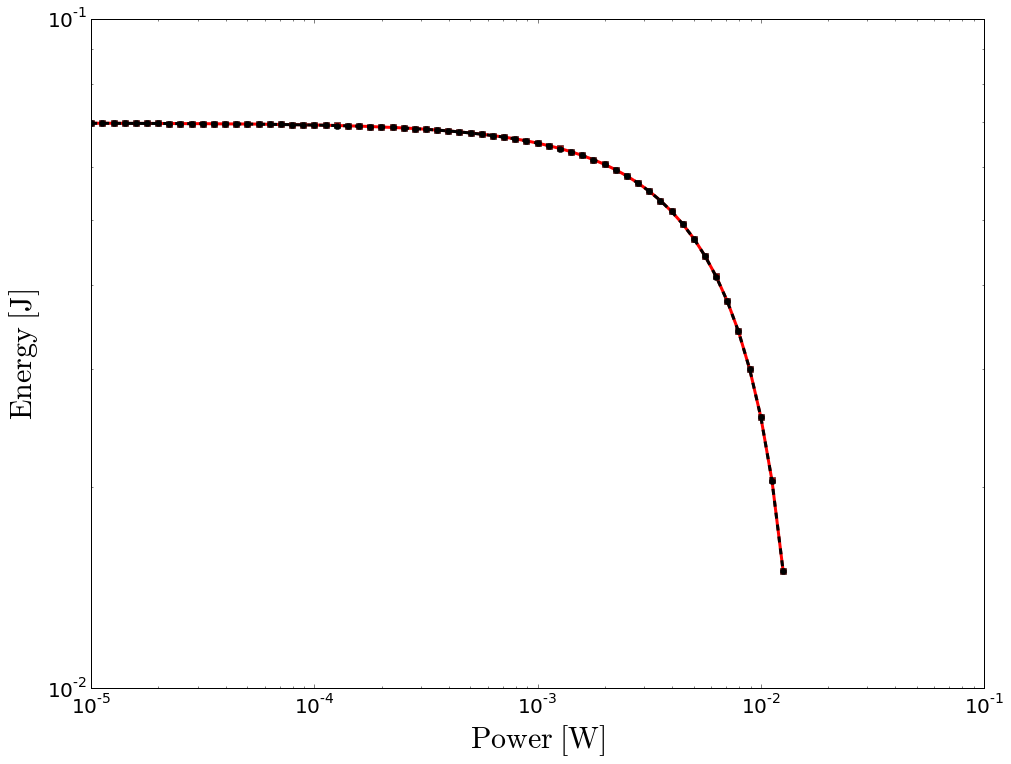

In [ ]:
# make a series RC equivalent circuit
device_database=PropertyTree()
device_database.put_string('type','SeriesRC')
device_database.put_double('series_resistance',R)
device_database.put_double('capacitance'      ,C)
device=EnergyStorageDevice(device_database)
# setup the experiment
ragone_database=setup_ragone_database()
# measure performance
ragone_chart_data=measure_ragone_chart(device,ragone_database)
P=ragone_chart_data['power']
E_computed=ragone_chart_data['energy']
# compute the exact answer
U_0=U_i/2+sqrt(U_i**2/4-R*P)
E_exact=C/2*(-R*P*log(U_0**2/U_f**2)+U_0**2-U_f**2)
# compare
error_norm=100*linalg.norm((E_computed-E_exact)/E_computed,inf)
print 'max pecent error = %e'%error_norm
percent_tolerance=0.1
assert error_norm<percent_tolerance
# plot
plot_ragone_chart(P,E_computed,E_exact)

# Parallel RC
The exact answer is given by:
\begin{equation}
E_{exact} = \frac{C}{2} \left( -R_L P\log\left( \frac{ \frac{U_{final}^2}{R_L} + P (1+\frac{R}{R_L}) }{ \frac{U_0^2}{R_L} + P (1+\frac{R}{R_L}) } \right) - \frac{R R_L}{R+R_L} P\log\left( \frac{ \frac{U_{final}^2}{R_L} + P (1+\frac{R}{R_L}) }{ \frac{U_0^2}{R_L} + P (1+\frac{R}{R_L}) } \frac{U_0^2}{U_{final}^2} \right) \right)
\end{equation}
where:
\begin{equation}
U_0 = \frac{U_{initial}}{2} + \sqrt{\frac{U_{initial}^2}{4}-RP}
\end{equation}

In [ ]:
# make a parallel RC equivalent circuit
device_database=PropertyTree()
device_database.put_string('type','ParallelRC')
device_database.put_double('series_resistance'  ,R  )
device_database.put_double('parallel_resistance',R_L)
device_database.put_double('capacitance'        ,C  )      
device=EnergyStorageDevice(device_database)
# setup the experiment
ragone_database=setup_ragone_database()
# measure performance
ragone_chart_data=measure_ragone_chart(device,ragone_database)
P=ragone_chart_data['power']
E_computed=ragone_chart_data['energy']
# compute the exact answer
U_0=U_i/2+sqrt(U_i**2/4-R*P)
tmp=(U_f**2/R_L+P*(1+R/R_L))/(U_0**2/R_L+P*(1+R/R_L))
E_exact=C/2*(-R_L*P*log(tmp)-R*R_L/(R+R_L)*P*log(tmp*U_0**2/U_f**2))
# compare
error_norm=100*linalg.norm((E_computed-E_exact)/E_computed,inf)
print 'max pecent error = %e'%error_norm
percent_tolerance=0.1
assert error_norm<percent_tolerance
# plot
plot_ragone_chart(P,E_computed,E_exact)